# Libraries & Packages

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [34]:
# gervasio file_path
g_path = r"C:\Users\gerva\OneDrive\Documentos\GitHub\ST498_CAPSTONE\FLASH\toShare"

In [35]:
# shruti


In [36]:
# fin
fin_path = "/Users/finbarrhodes/Documents/Github/ST498_CAPSTONE/FLASH/toShare"

In [37]:
file_name = r"/controleConsolide.csv"
csv_path = fin_path + file_name
df_control_Consolide = pd.read_csv(csv_path)

In [38]:
file_name = r"/socioEcodata.csv"
csv_path = fin_path + file_name
df_socio = pd.read_csv(csv_path)

In [39]:
csv_path = fin_path + file_name
df = pd.read_csv(csv_path)

## Generic Data comments:
1. Socioeconomic info for 1138 ANON_IDs with a total of 18 columns
2. ControlConsolide has 11420 half-hour readings for 506 ANON_IDs
3. Socioeconomic has no repeated features nor ANON_IDs
4. In ControlConsolide, 487 / 506 ANON_IDs dhave socioeconomic features
5. The timeframe of ControlConsolide is 2024-04-01 to 2024-12-31


In [40]:
df_control_Consolide.shape

(11420, 507)

In [41]:
cols_control_consolide = df_control_Consolide.columns
cols_control_consolide

Index(['Unnamed: 0',
       '8d606eeffaed80dba63c8b58b3c8c5268854bb561079c9c09ed798b4262b0c1c',
       'ba0094d2fc8a6a5f53ac93dbe2ebea54077fe5d2dc594254669bdabf72ac600c',
       'ada98028886af1bf82c80007c8caf4a1045ca4ca6a95c4abc3989cb47c2da951',
       'fab120413635603ab2931eb5038f9d31a0405966bb5e9c412786fa90938a063d',
       '2ac811d32213336ffe6ce8690f58bdb499a34fccc658139f645443d0f34d4fd0',
       '22aa8a39c51f9a1e17a12a56cef8d9879376de8279f795f6c77984c8f9ff08ba',
       'db43cb0470dd2b6041a2da6064e702f20288c86fb9680f91ac0a766b9feadf89',
       '1bb0dbb267bb04114ec5f07e40a19a36dda7b37afb7168d51af3b518529e6e4a',
       '77848ee8042a4f425374331030f02bb162e035ced5dabaeb48e1972fffa56c70',
       ...
       '6d1ab9d031170c929f9fc172e706c1b24714af8b4c76d6c4747de0bda86f4858',
       '537560494f4581ede39d8f144617d4ca647eb91e83de7043bf423bf71009d143',
       '534f6e857277a273da94d667d24de3c9c64a92ba4229c40c7736916b4407466e',
       '4e2996f6917e0f84c5c24436a83320667ec5b23209643a108b293c05b6c7

In [42]:
df_control_Consolide.head()

,Unnamed: 0,8d606eeffaed80dba63c8b58b3c8c5268854bb561079c9c09ed798b4262b0c1c,ba0094d2fc8a6a5f53ac93dbe2ebea54077fe5d2dc594254669bdabf72ac600c,ada98028886af1bf82c80007c8caf4a1045ca4ca6a95c4abc3989cb47c2da951,fab120413635603ab2931eb5038f9d31a0405966bb5e9c412786fa90938a063d,2ac811d32213336ffe6ce8690f58bdb499a34fccc658139f645443d0f34d4fd0,22aa8a39c51f9a1e17a12a56cef8d9879376de8279f795f6c77984c8f9ff08ba,db43cb0470dd2b6041a2da6064e702f20288c86fb9680f91ac0a766b9feadf89,1bb0dbb267bb04114ec5f07e40a19a36dda7b37afb7168d51af3b518529e6e4a,77848ee8042a4f425374331030f02bb162e035ced5dabaeb48e1972fffa56c70,...,6d1ab9d031170c929f9fc172e706c1b24714af8b4c76d6c4747de0bda86f4858,537560494f4581ede39d8f144617d4ca647eb91e83de7043bf423bf71009d143,534f6e857277a273da94d667d24de3c9c64a92ba4229c40c7736916b4407466e,4e2996f6917e0f84c5c24436a83320667ec5b23209643a108b293c05b6c70bf0,6ca1d30be59b8c4f8b742b98e45783351102b09d9f480d5ca17f7083903dea6b,e2014419ea47af5e5ce317354b4373b9d838b4eb84dc84e1673181b7f89cb0b1,64000e9e9401f80528e23c0eb788c22e7b6941f226b3923b12702c6e34b5286c,1dbfe0beadaabca9c0e36c695323800a119e7aac3e1e879e572b07da7cc941f1,e1918870bfb823bf749e6ec4c180ccb9668eb82fa4f56531491d48031231b5f0,ccda3cf02d63eb6357954d94acc8aae83535124d2860850317564eae4435e160
0,2024-04-01 00:00:00,0.020,0.083,0.037,0.081,0.109,0.112,0.018,0.026,0.075,...,0.135,0.021,0.168,0.111,0.251,0.037,0.026,NaN,0.026,NaN
1,2024-04-01 00:30:00,0.063,0.095,0.033,0.093,0.091,0.110,0.029,0.036,0.131,...,0.119,0.023,0.282,0.114,0.216,0.054,0.039,NaN,0.035,NaN
2,2024-04-01 01:00:00,0.047,0.088,0.038,0.098,0.112,0.102,0.060,0.016,0.047,...,0.105,0.033,0.252,0.132,0.235,0.034,0.027,NaN,0.047,NaN
3,2024-04-01 01:30:00,0.015,0.076,0.035,0.072,0.113,0.123,0.026,0.020,0.068,...,0.101,0.035,0.198,0.133,0.280,0.048,0.034,NaN,0.026,NaN
4,2024-04-01 02:00:00,0.051,0.094,0.063,0.078,0.077,0.127,0.015,0.038,0.104,...,0.090,0.021,0.076,0.124,0.216,0.035,0.033,NaN,0.038,NaN


In [43]:
print(df_socio.shape)
print(df_socio.columns)
df_socio.head()


(1138, 18)
Index(['HASH_KEY', 'AGE_GROUP', 'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY',
       'CHILDREN_AT_HOME', 'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS',
       'OCCUPATION', 'EMPLOYMENT_STATUS', 'HIGHEST_QUALIFICATION',
       'HOME_OWNERSHIP', 'HOME_TYPE', 'HOME_VALUE', 'SOCIAL_GRADE',
       'TARIFF_GROUP', 'ESTIMATED_CONSUMPTION_ELEC_DAY',
       'ESTIMATED_CONSUMPTION_ELEC_NIGHT', 'ESTIMATED_CONSUMPTION_TOTAL'],
      dtype='object')


,HASH_KEY,AGE_GROUP,INCOME_CATEGORY,HOUSEHOLD_OCCUPANCY,CHILDREN_AT_HOME,HOUSEHOLD_SIZE,NUMBER_OF_BEDROOMS,OCCUPATION,EMPLOYMENT_STATUS,HIGHEST_QUALIFICATION,HOME_OWNERSHIP,HOME_TYPE,HOME_VALUE,SOCIAL_GRADE,TARIFF_GROUP,ESTIMATED_CONSUMPTION_ELEC_DAY,ESTIMATED_CONSUMPTION_ELEC_NIGHT,ESTIMATED_CONSUMPTION_TOTAL
0,8399087eaac9d88e3c6fce0c76484d18a40576c2fd46b7...,35-44,"50,000-74,999",Couple Household,0,2,3,Professional,Employed,University Degree or Higher,Owner Occupied,Semi-Detached House,250-500k,Social grade B,Deemed,2088,0,2088
1,b2d78d29b401e989873368a90f4079ba17bf5448db4c73...,65-74,"30,000-39,999",Couple Household,0,2,3,Retired,Not Employed,A Level Equivalent,Owner Occupied,Semi-Detached House,250-500k,Social grade C1,EDF Essentials,2422,0,2422
2,dc1ec3fca1531822856b50fabe334a17a6053dccb66498...,55-64,"0-9,999",Single Adult Household,0,1,1,Director/Managerial,Employed,University Degree or Higher,Owner Occupied,Flat or Maisonette,250-500k,Social grade C1,Safeguard Assist,1374,0,1374
3,cd68542ea1a700c995074c15c8f41973443359a9bbff2a...,75+,"20,000-29,999",Single Adult Household,0,1,1,Retired,Not Employed,University Degree or Higher,Owner Occupied,Flat or Maisonette,250-500k,Social grade C1,EDF Essentials,2619,0,2619
4,fef90b0143496f6e158ba9db416049340d590648659fc6...,55-64,"100,000+",Couple Household,0,2,4,Professional,Employed,University Degree or Higher,Owner Occupied,Detached House,250-500k,Social grade B,Standard,5504,0,5504


In [44]:
common_keys = df_socio['HASH_KEY'].isin(cols_control_consolide)
print(f"Number of matching entries: {common_keys.sum()}")

Number of matching entries: 487


In [45]:
# Count the number of duplicate HASH_KEY values
duplicate_counts = df_socio['HASH_KEY'].duplicated().sum()
print(f"Number of duplicate HASH_KEY entries: {duplicate_counts}")

Number of duplicate HASH_KEY entries: 0


In [46]:
# Get all column names from df_control_Consolide
cols_control_consolide = set(df_control_Consolide.columns)

# Check which columns are NOT in df_socio['HASH_KEY']
missing_cols = cols_control_consolide - set(df_socio['HASH_KEY'])

print("Columns in df_control_Consolide that are NOT in df_socio['HASH_KEY']:")
print(missing_cols)


Columns in df_control_Consolide that are NOT in df_socio['HASH_KEY']:
{'Unnamed: 0', '1e1bfa63fff199a44b7b248c11265dd721b33f1d2edc7e9fae9f714bbba78564', '585675d4b905182ed7cee11a72597a682fbca36da153f6116fec806cf96ab0d5', '31997152c8a481c326d6cb05abbd7690403eaf513945e1aba3279f31d344c956', '974b62dc16b47fde35954aa89d621c6b059df2f8ecb0ff463bd8421decfe2b4b', '5a1201e13a1fb54fdcd682525db62a20f48e9c30fa6377ecebd4773be01cab6e', 'bbd37f115949e74f97d7fbb407e3ed505bc179507d744340dace2d71a5813950', 'e2014419ea47af5e5ce317354b4373b9d838b4eb84dc84e1673181b7f89cb0b1', 'a98f6c19e507bf7c07198b49919613e17465c9fffa59c6bc7ac0eeeb40ea217d', '018e0c5cf686da1b7ac2d170d54aba9263fdc420b65ff5e71d4539e926385772', '4ad2ed550310d9cf0c25d61b26241b9b93acf744c28ae75b3860fedcbeaddc47', '6dde0e5269f557dc5530f5107a9ad925b7fafc6a52d4f6fef834a0e23fd8b63c', 'f2abe7cbb5a60b61d874165fb6a1f0c7fcd4c33b8483759bc102ce4fbdf66365', 'f4c3bcbc7dd37e40f8f6238c94fd99b4e488f7ec07f54dbd53849f23d0c34e1f', '0a67e7537bf618ab4f6983665d02d2

# EDA

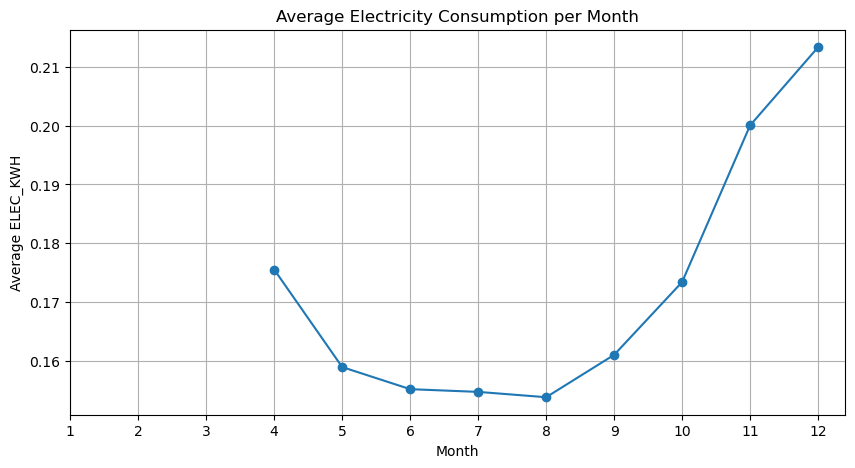

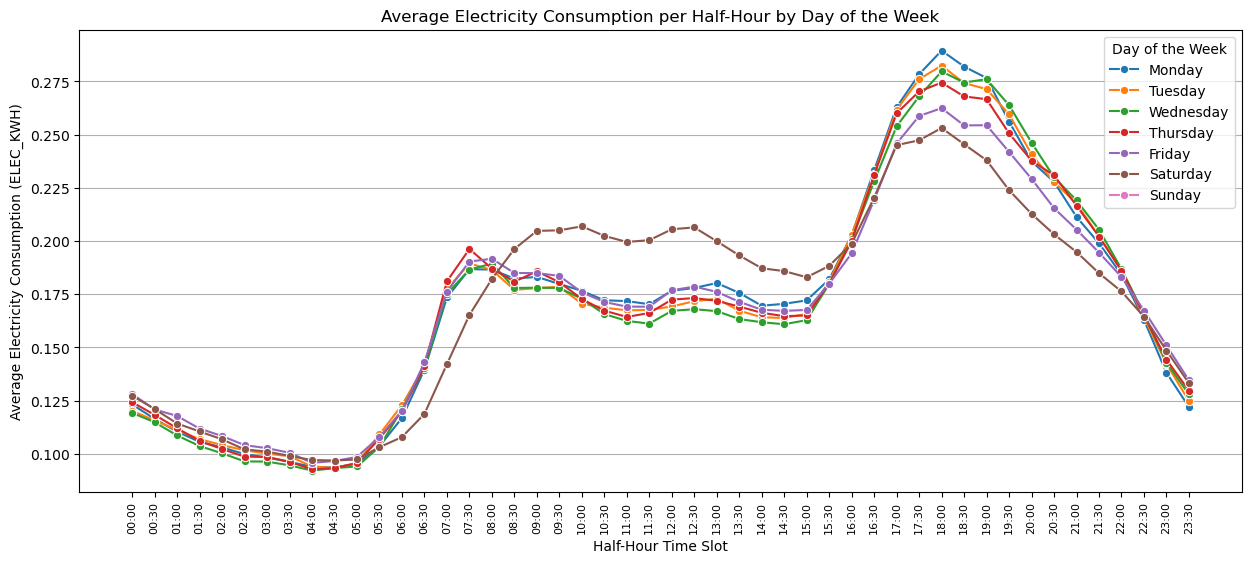

<Figure size 1500x600 with 0 Axes>

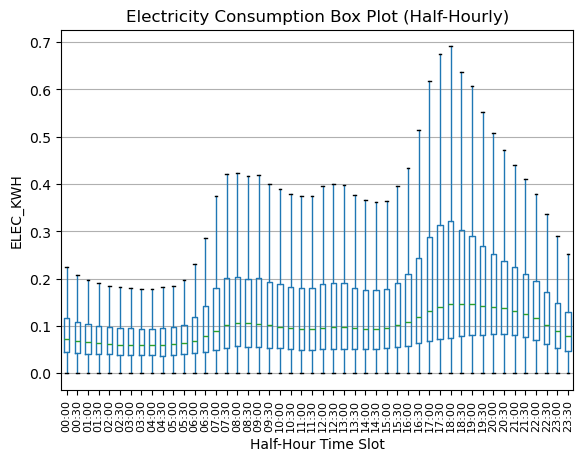

In [47]:
df_control_Consolide = df_control_Consolide.rename(columns={'Unnamed: 0': 'Time'})
df_control_Consolide['Time'] = pd.to_datetime(df_control_Consolide['Time'])

# Unpivot (melt) the dataset: Convert wide format to long format
df_control_Consolide_long = df_control_Consolide.melt(id_vars=['Time'], var_name='ANON_ID', value_name='ELEC_KWH')
df_control_Consolide_long['Month'] = df_control_Consolide_long['Time'].dt.month
df_control_Consolide_long['DayOfWeek'] = df_control_Consolide_long['Time'].dt.day_name()
df_control_Consolide_long['HalfHour'] = df_control_Consolide_long['Time'].dt.strftime('%H:%M')  # Captures half-hourly reading format


## 1. Plot: Average Consumption Across Months
monthly_avg = df_control_Consolide_long.groupby('Month')['ELEC_KWH'].mean()

plt.figure(figsize=(10,5))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Average ELEC_KWH')
plt.title('Average Electricity Consumption per Month')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()


# Compute the average ELEC_KWH for each HalfHour and DayOfWeek across all ANON_IDs
df_avg_halfhour = df_control_Consolide_long.groupby(['HalfHour', 'DayOfWeek'])['ELEC_KWH'].mean().reset_index()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_avg_halfhour['DayOfWeek'] = pd.Categorical(df_avg_halfhour['DayOfWeek'], categories=day_order, ordered=True)

# Plot: Line chart for average electricity consumption per half-hour slot, with each line representing a day of the week
plt.figure(figsize=(15,6))
sns.lineplot(data=df_avg_halfhour, x="HalfHour", y="ELEC_KWH", hue="DayOfWeek", marker="o")
plt.xlabel("Half-Hour Time Slot")
plt.ylabel("Average Electricity Consumption (ELEC_KWH)")
plt.title("Average Electricity Consumption per Half-Hour by Day of the Week")
plt.xticks(rotation=90, fontsize=8)
plt.legend(title="Day of the Week", bbox_to_anchor=(1, 1))
plt.grid(axis='y')
plt.show()

## 3 Boxplot: Consumption Across Half-Hour Intervals Over the Year
plt.figure(figsize=(15,6))
df_control_Consolide_long.boxplot(column='ELEC_KWH', by='HalfHour', grid=False, showfliers=False)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Half-Hour Time Slot')
plt.ylabel('ELEC_KWH')
plt.title('Electricity Consumption Box Plot (Half-Hourly)')
plt.suptitle('')  # Remove default boxplot title
plt.grid(axis='y')
plt.show()


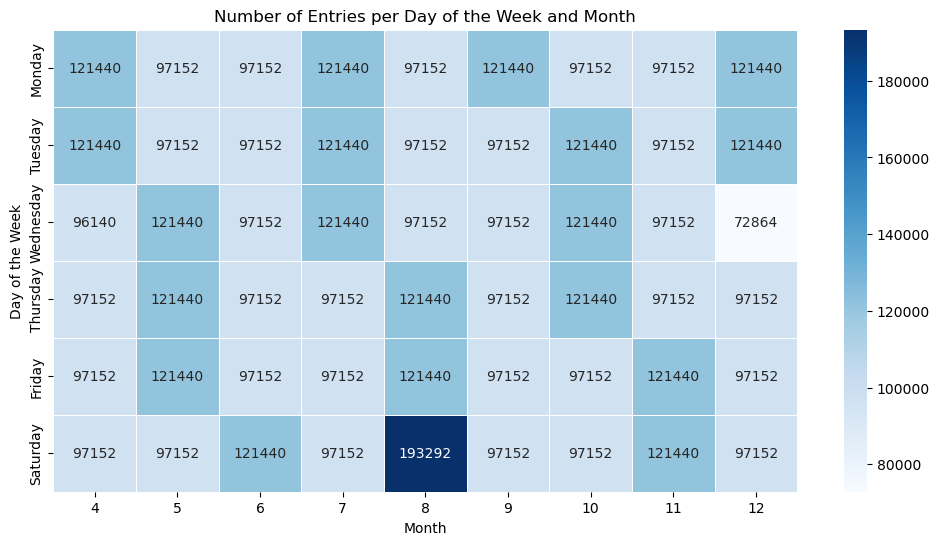

In [48]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Count occurrences per (Month, DayOfWeek)
entries_count = df_control_Consolide_long.groupby(['DayOfWeek', 'Month']).size().unstack()
entries_count = entries_count.reindex(day_order)


plt.figure(figsize=(12,6))
sns.heatmap(entries_count, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Month")
plt.ylabel("Day of the Week")
plt.title("Number of Entries per Day of the Week and Month")
plt.show()



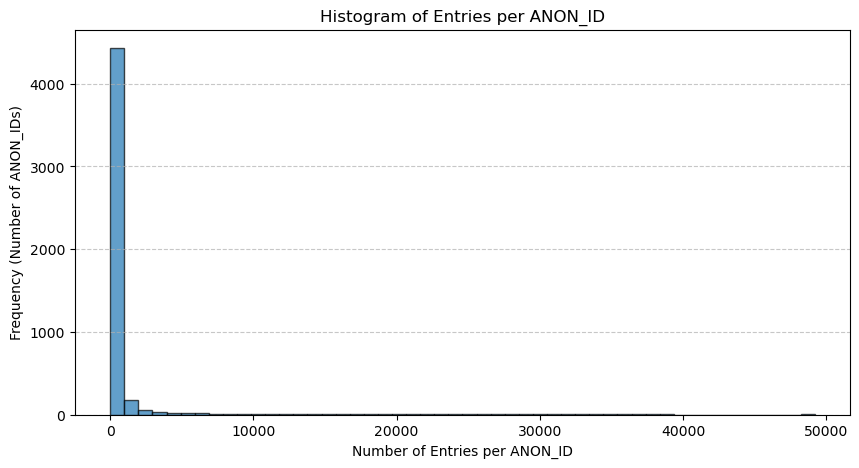

In [49]:
import matplotlib.pyplot as plt

# Count the number of entries per ANON_ID
anon_id_entry_counts = df_control_Consolide_long.groupby('ELEC_KWH').size()

# Plot histogram
plt.figure(figsize=(10,5))
plt.hist(anon_id_entry_counts, bins=50, edgecolor='black', alpha=0.7)

# Formatting the plot
plt.xlabel("Number of Entries per ANON_ID")
plt.ylabel("Frequency (Number of ANON_IDs)")
plt.title("Histogram of Entries per ANON_ID")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


# Preprocessing

Making IDs for households and a dictionary matching IDs to hash keys to then drop the hash keys to improve readability

In [50]:
file_name = r"/socioEcodata.csv"
csv_path = fin_path + file_name
df_socio = pd.read_csv(csv_path)
df_socio['ANON_ID'] = range(1,len(df_socio) + 1) # make IDs
id_dict = df_socio.set_index('HASH_KEY')['ANON_ID'].to_dict() # make dictionary with ID-hash key pairs 
df_socio = df_socio.drop(columns="HASH_KEY") # drop hash keys from table 

In [51]:
id_dict
df_socio

,AGE_GROUP,INCOME_CATEGORY,HOUSEHOLD_OCCUPANCY,CHILDREN_AT_HOME,HOUSEHOLD_SIZE,NUMBER_OF_BEDROOMS,OCCUPATION,EMPLOYMENT_STATUS,HIGHEST_QUALIFICATION,HOME_OWNERSHIP,HOME_TYPE,HOME_VALUE,SOCIAL_GRADE,TARIFF_GROUP,ESTIMATED_CONSUMPTION_ELEC_DAY,ESTIMATED_CONSUMPTION_ELEC_NIGHT,ESTIMATED_CONSUMPTION_TOTAL,ANON_ID
0,35-44,"50,000-74,999",Couple Household,0,2,3,Professional,Employed,University Degree or Higher,Owner Occupied,Semi-Detached House,250-500k,Social grade B,Deemed,2088,0,2088,1
1,65-74,"30,000-39,999",Couple Household,0,2,3,Retired,Not Employed,A Level Equivalent,Owner Occupied,Semi-Detached House,250-500k,Social grade C1,EDF Essentials,2422,0,2422,2
2,55-64,"0-9,999",Single Adult Household,0,1,1,Director/Managerial,Employed,University Degree or Higher,Owner Occupied,Flat or Maisonette,250-500k,Social grade C1,Safeguard Assist,1374,0,1374,3
3,75+,"20,000-29,999",Single Adult Household,0,1,1,Retired,Not Employed,University Degree or Higher,Owner Occupied,Flat or Maisonette,250-500k,Social grade C1,EDF Essentials,2619,0,2619,4
4,55-64,"100,000+",Couple Household,0,2,4,Professional,Employed,University Degree or Higher,Owner Occupied,Detached House,250-500k,Social grade B,Standard,5504,0,5504,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,45-54,"0-9,999",Single Adult Household,0,1,2,Service Sector,Employed,GCSE Equivalent,Private Renting,Flat or Maisonette,100-150k,Social grade C1,EDF Essentials,6038,0,6038,1134
1134,65-74,"40,000-49,999",Couple Household,0,2,3,Retired,Not Employed,A Level Equivalent,Owner Occupied,Semi-Detached House,250-500k,Social grade B,Deemed,3528,0,3528,1135
1135,45-54,"50,000-74,999",Couple Household,2+,3-4,3,Professional,Employed,GCSE Equivalent,Owner Occupied,Semi-Detached House,250-500k,Social grade B,Standard,3911,0,3911,1136
1136,55-64,"20,000-29,999",Couple Household,0,2,3,Office Worker,Employed,GCSE Equivalent,Owner Occupied,Terraced House,150-250k,Social grade C1,Standard,1863,0,1863,1137


In [ ]:
# df_control_Consolide = df_control_Consolide.rename(columns=id_dict)

def subset_for_socio(df, dict):
    """
    Subsets a DataFrame by columns that exist in a given dictionary.
    
    Args:
    df (pd.DataFrame): The DataFrame to subset.
    column_dict (dict): The dictionary where keys represent the columns to retain.
    
    Returns:
    pd.DataFrame: A DataFrame with only the columns found in the dictionary.
    """
    # Get the list of columns that exist in both the dataframe and the dictionary
    columns_to_keep = [col for col in df.columns if col in dict]
    print(columns_to_keep)
    
    # Return the subset DataFrame with the desired columns
    return df[columns_to_keep]

subset_for_socio(df_socio, list(id_dict.keys()))

In [58]:
len([col for col in df_control_Consolide.columns if col in list(id_dict)])

487

Notes: 

- controlConsolide has households that don't have socioeconomic data accompanying them. 
    - Possible Actions: split IDs sets into ones with and without 

In [175]:
# functions from first_checkpoint.ipynb script
# can be edited; less data -> less classes all around 
# from last meeting: different day classes beyond maybe just weekend vs weekday is not feasible 
# further: paper with day and month class breakdowns used all typed of consumers, not just households 
def get_day_class(day):
    if day == 0:  # Monday
        return 1
    elif day in [1, 2, 3]:  # Tuesday, Wednesday, Thursday
        return 2
    elif day == 4:  # Friday
        return 3
    elif day == 5:  # Saturday
        return 4
    elif day == 6:  # Sunday
        return 5

def get_month_class(month):
    if month in [12, 1, 2]:  # Dec, Jan, Feb
        return 1
    elif month == 3:  # March
        return 2
    elif month in [4, 5]:  # April, May
        return 3
    elif month in [6, 7, 9]:  # June, July, September
        return 4
    elif month == 8:  # August
        return 5
    elif month == 10:  # October
        return 6
    elif month == 11:  # November
        return 7

In [131]:
import pandas as pd
import numpy as np

def flash_filter(df, column_mapping):
    """
    Transform a dataframe by:
    a) Renaming columns using the provided mapping dictionary
    b) Dropping columns that are not in the mapping dictionary
    c) Dropping columns with any NA/NaN values
    
    Parameters:
    df (pandas.DataFrame): The original dataframe with hash key columns
    column_mapping (dict): Dictionary mapping hash keys to column IDs
    
    Returns:
    pandas.DataFrame: The transformed dataframe
    """
    # Step 1: Keep only columns that are in the mapping dictionary
    columns_to_keep = [col for col in df.columns if col in column_mapping]
    df_filtered = df[columns_to_keep].copy()
    
    # Step 2: Rename the columns using the mapping dictionary
    rename_dict = {col: column_mapping[col] for col in columns_to_keep}
    df_renamed = df_filtered.rename(columns=rename_dict)
    
    # Step 3: Drop columns with any NA or NaN values
    # This gets columns that have at least one NA
    """columns_with_na = df_renamed.columns[df_renamed.isna().any()].tolist()
    df_final = df_renamed.drop(columns=columns_with_na)"""
    
    return df_renamed

# Example usage:
# Assuming df is your original dataframe and column_mapping is your dictionary
# column_mapping = {'hash_key1': 'column_id1', 'hash_key2': 'column_id2', ...}
# transformed_df = transform_dataset(df, column_mapping)

In [132]:
# flash = flash_filter(df_control_Consolide, id_dict)

In [205]:
cleaned = df_control_Consolide.rename(columns=id_dict)
for i in cleaned.columns:
    if type(i) == 'str' and len(i) > 10:
        cleaned.drop(columns=i)
    if np.isnan(cleaned[i]).sum() > 0:
        cleaned.drop(columns=i)

# cleaned = cleaned.drop(columns='Time')

In [208]:
flash = pd.melt(cleaned, id_vars='Time', var_name='ID', value_name='kWh')


# adding HH interval
hh = (flash['Time'].dt.hour * 2 + (flash['Time'].dt.minute >= 30).astype(int))
flash.insert(3,'HH',hh)
# adding month
month = flash['Time'].dt.month
flash.insert(4,'Month',month)
# adding day class
day_class = flash['Time'].dt.weekday.apply(get_day_class)
flash.insert(5, 'Day Class', day_class)
# adding month class
month_class = flash['Time'].dt.month.apply(get_month_class)
flash.insert(6, 'Month Class', month_class)

In [209]:
flash

,Time,ID,kWh,HH,Month,Day Class,Month Class
0,2024-04-01 00:00:00,681,0.020,0,4,1,3
1,2024-04-01 00:30:00,681,0.063,1,4,1,3
2,2024-04-01 01:00:00,681,0.047,2,4,1,3
3,2024-04-01 01:30:00,681,0.015,3,4,1,3
4,2024-04-01 02:00:00,681,0.051,4,4,1,3
...,...,...,...,...,...,...,...
5778515,2024-12-31 21:30:00,811,0.203,43,12,2,1
5778516,2024-12-31 22:00:00,811,0.213,44,12,2,1
5778517,2024-12-31 22:30:00,811,0.225,45,12,2,1
5778518,2024-12-31 23:00:00,811,0.192,46,12,2,1


In [203]:
flash.pivot(index='ID', columns='HH', values='kWh')

ValueError: Index contains duplicate entries, cannot reshape